# Implementación de modelo de ML para Creditos en Alemania

In [548]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbs
import sklearn
import openml as oml

sbs.set_style('darkgrid')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [553]:
api = open("""C:\\Users\\Alfred\\PycharmProjects\\Clases_Programacion\\OpenML_API.txt""").read()
oml.config.apikey = api

Author: Dr. Hans Hofmann  
Source: [UCI](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)) - 1994    
Please cite: [UCI](https://archive.ics.uci.edu/ml/citation_policy.html)

German Credit dataset  
This dataset classifies people described by a set of attributes as good or bad credit risks.

This dataset comes with a cost matrix: 
``` 
      Good  Bad (predicted)  
Good   0    1   (actual)  
Bad    5    0  
```

It is worse to class a customer as good when they are bad (5), than it is to class a customer as bad when they are good (1).  

### Attribute description  

1. Status of existing checking account, in Deutsche Mark.  
2. Duration in months  
3. Credit history (credits taken, paid back duly, delays, critical accounts)  
4. Purpose of the credit (car, television,...)  
5. Credit amount  
6. Status of savings account/bonds, in Deutsche Mark.  
7. Present employment, in number of years.  
8. Installment rate in percentage of disposable income  
9. Personal status (married, single,...) and sex  
10. Other debtors / guarantors  
11. Present residence since X years  
12. Property (e.g. real estate)  
13. Age in years  
14. Other installment plans (banks, stores)  
15. Housing (rent, own,...)  
16. Number of existing credits at this bank  
17. Job  
18. Number of people being liable to provide maintenance for  
19. Telephone (yes,no)  
20. Foreign worker (yes,no)

In [562]:
task=oml.tasks.get_task(31)
dataset = task.get_dataset()

OpenML Dataset
Name..........: credit-g
Version.......: 1
Format........: ARFF
Upload Date...: 2014-04-06 23:21:47
Licence.......: Public
Download URL..: https://www.openml.org/data/v1/download/31/credit-g.arff
OpenML URL....: https://www.openml.org/d/31
# of features.: 21
# of instances: 1000

In [658]:
data = dataset.get_data()

data,_,_,_ = data

target= data['class']

data.drop('class', axis=1, inplace=True)

In [659]:
#data = pd.read_csv('dataset_31_credit-g.csv')
#target = data['class'].values
#data.drop('class', axis=1, inplace=True)
#data

In [660]:
target[:5]

0    good
1     bad
2    good
3    good
4     bad
Name: class, dtype: category
Categories (2, object): ['good' < 'bad']

Reinterpretamos target para que bad sea 0. Por lo tanto, los coeficientes positivos, son "buenos", y los negativos son "malos".

In [661]:
target=np.where(target=='good',1,0)
target[:10]

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 0])

# Analisis de datos

In [662]:
data.columns

Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker'],
      dtype='object')

## Analisis univariado

### checking_status

In [663]:
data.checking_status.value_counts()

no checking    394
<0             274
0<=X<200       269
>=200           63
Name: checking_status, dtype: int64

Variable cualitativa.   
**Expectativa:** no checking y saldo menor a cero sean negativos en cuanto a calidad cred.

### duration

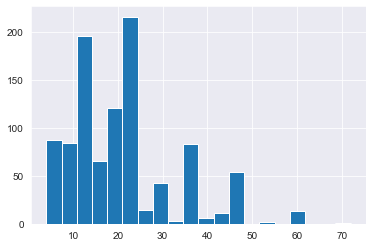

In [664]:
plt.hist(data.duration, bins=20)
plt.show()

Distribucion asimétrica, agrupada en la parte corta de la curva.  

**Expectativa:** las duraciones mas largas tendrán menos problemas en calidad

### credit_history

In [665]:
data.credit_history.value_counts()

existing paid                     530
critical/other existing credit    293
delayed previously                 88
all paid                           49
no credits/all paid                40
Name: credit_history, dtype: int64

### purpose

In [666]:
data['purpose'].value_counts()

radio/tv               280
new car                234
furniture/equipment    181
used car               103
business                97
education               50
repairs                 22
other                   12
domestic appliance      12
retraining               9
vacation                 0
Name: purpose, dtype: int64

**Expectativa:** Aplicaciones comerciales y de inversión (eg. educación) tendrán menos riesgo que creditos de consumo.

<AxesSubplot:>

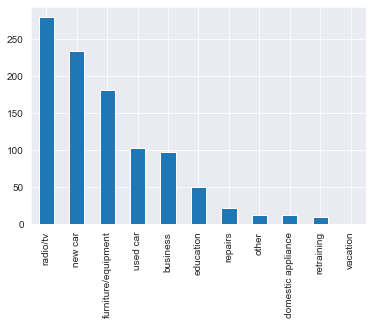

In [667]:
data['purpose'].value_counts().plot(kind='bar')

### credit_amount

(array([445., 293.,  97.,  80.,  38.,  19.,  14.,   8.,   5.,   1.]),
 array([  250. ,  2067.4,  3884.8,  5702.2,  7519.6,  9337. , 11154.4,
        12971.8, 14789.2, 16606.6, 18424. ]),
 <BarContainer object of 10 artists>)

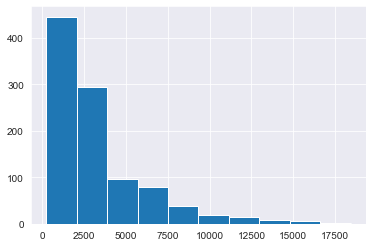

In [668]:
plt.hist(data.credit_amount, bins=10)

### savings_status

<AxesSubplot:>

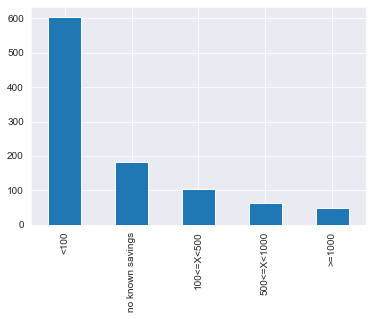

In [669]:
data.savings_status.value_counts().plot(kind='bar')

### employment

<AxesSubplot:>

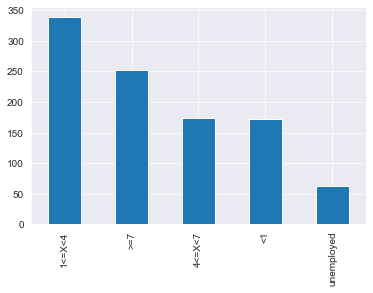

In [670]:
data.employment.value_counts().plot(kind='bar')

**Expectativa:** mayor antiguedad debería correlacionar mejor con estabilidad laboral, por lo tanto, con calidad crediticia.

### installment_commitment

<AxesSubplot:>

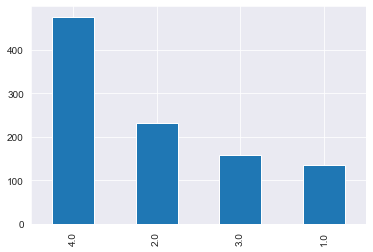

In [671]:
data.installment_commitment.value_counts().plot(kind='bar')

% del salario ocupado por cada amortización

**Expectativa:** mas es peor calidad.

### personal_status

In [672]:
data.personal_status.value_counts()

male single           548
female div/dep/mar    310
male mar/wid           92
male div/sep           50
female single           0
Name: personal_status, dtype: int64

### other_parties

In [673]:
data.other_parties.value_counts()

none            907
guarantor        52
co applicant     41
Name: other_parties, dtype: int64

### residence_since

In [674]:
data.residence_since.value_counts()

4.0    413
2.0    308
3.0    149
1.0    130
Name: residence_since, dtype: int64

**Expectativa:** mayor antiguedad debería correlacionar con calidad crediticia.

### property_magnitude

In [675]:
data.property_magnitude.value_counts()

car                  332
real estate          282
life insurance       232
no known property    154
Name: property_magnitude, dtype: int64

### age

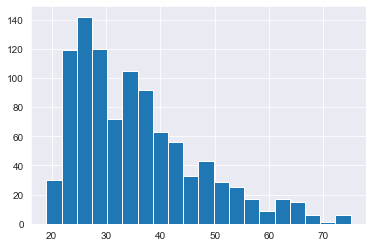

In [676]:
plt.hist(data.age, bins=20)
plt.show()

**Expectativa:** mayor edad debería correlacionar con riqueza, y por ende, calidad crediticia.

### other_payment_plans



In [677]:
data.other_payment_plans.value_counts()

none      814
bank      139
stores     47
Name: other_payment_plans, dtype: int64

### housing

<AxesSubplot:>

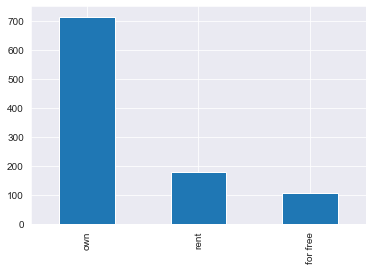

In [678]:
data.housing.value_counts().plot(kind='bar')

**Expectativa:** alquilar genera salidas de flujos de fondos mensuales y se asocian con menor riqueza, lo que impacta en calidad crediticia. Adicionalmente, propietarios podrían refinanciar con creditos hipotecarios.

### existing_credits

In [679]:
data.existing_credits.value_counts()

1.0    633
2.0    333
3.0     28
4.0      6
Name: existing_credits, dtype: int64

### job

In [680]:
data.job.value_counts()

skilled                      630
unskilled resident           200
high qualif/self emp/mgmt    148
unemp/unskilled non res       22
Name: job, dtype: int64

### num_dependents

<AxesSubplot:>

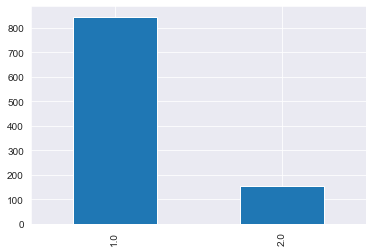

In [681]:
data.num_dependents.value_counts().plot(kind='bar')

### own_telephone

In [682]:
data.own_telephone.value_counts()

none    596
yes     404
Name: own_telephone, dtype: int64

### foreign_worker



In [683]:
data.foreign_worker.value_counts()

yes    963
no      37
Name: foreign_worker, dtype: int64

**Expectativa:** Ser extranjero correlaciona con los costos de instalarse y falta de redes. Por tanto, es negativo para la calidad crediticia.

## Analisis multivariado

### Duration vs. Credit amount

C:\Users\Alfred\Anaconda3\envs\pythonforfinance\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


array([[<AxesSubplot:xlabel='duration', ylabel='duration'>,
        <AxesSubplot:xlabel='credit_amount', ylabel='duration'>],
       [<AxesSubplot:xlabel='duration', ylabel='credit_amount'>,
        <AxesSubplot:xlabel='credit_amount', ylabel='credit_amount'>]],
      dtype=object)

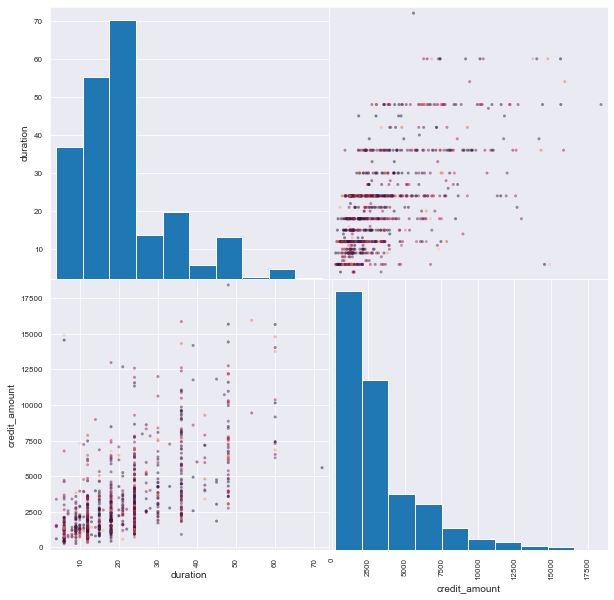

In [684]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
pd.plotting.scatter_matrix(data[['duration', 'credit_amount']], c=data.age ,ax=ax, grid=True)

In [685]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression().fit(data.duration.values.reshape(-1, 1), data.credit_amount)

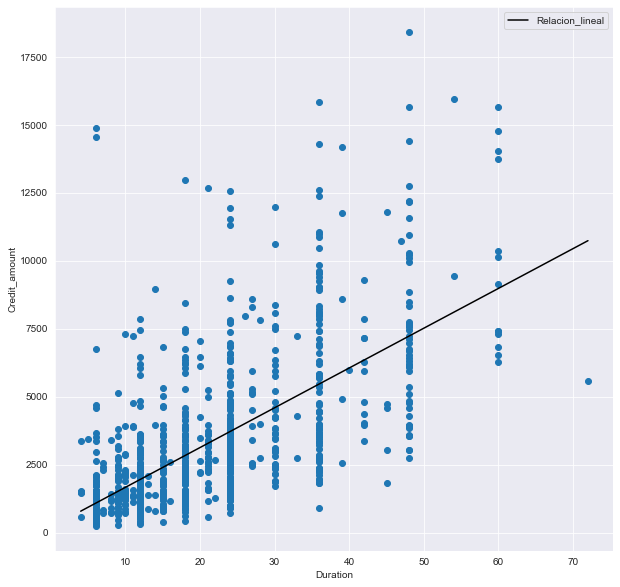

In [686]:
line = np.linspace(data.duration.min(), data.duration.max())
linrel = linreg.intercept_ + linreg.coef_*line

fig, ax = plt.subplots(1,1, figsize=(10,10))
plt.scatter(data.duration, data.credit_amount)
plt.plot(line, linrel, label='Relacion_lineal', c='k')
plt.xlabel('Duration')
plt.ylabel('Credit_amount')
plt.legend()
plt.show()

Vemos una relación relativamente fuerte y positiva entre el monto y la duración del crédito.

### Duration vs. age

C:\Users\Alfred\Anaconda3\envs\pythonforfinance\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


array([[<AxesSubplot:xlabel='credit_amount', ylabel='credit_amount'>,
        <AxesSubplot:xlabel='age', ylabel='credit_amount'>],
       [<AxesSubplot:xlabel='credit_amount', ylabel='age'>,
        <AxesSubplot:xlabel='age', ylabel='age'>]], dtype=object)

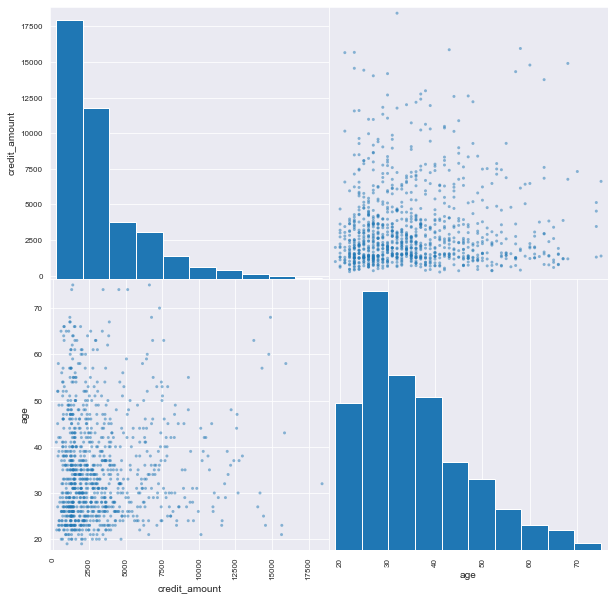

In [687]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
pd.plotting.scatter_matrix(data[['credit_amount', 'age']] ,ax=ax, grid=True)

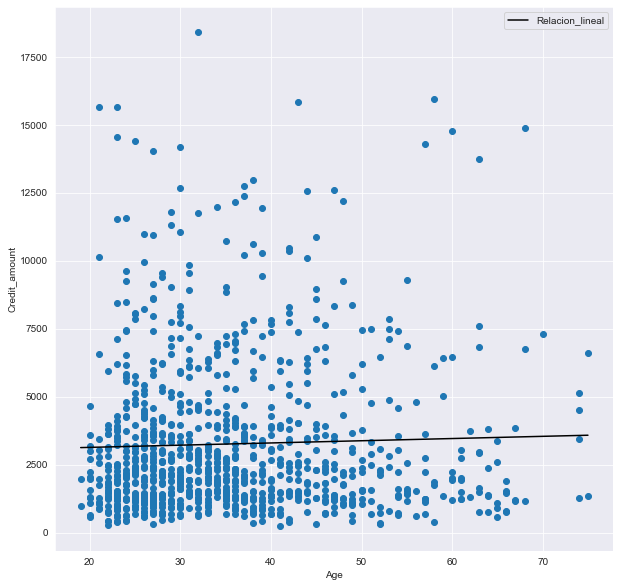

In [688]:
linreg = LinearRegression().fit(data.age.values.reshape(-1, 1), data.credit_amount)

line = np.linspace(data.age.min(), data.age.max())
linrel = linreg.intercept_ + linreg.coef_*line


fig, ax = plt.subplots(1,1, figsize=(10,10))
plt.scatter(data.age, data.credit_amount)
plt.plot(line, linrel, label='Relacion_lineal', c='k')
plt.xlabel('Age')
plt.ylabel('Credit_amount')
plt.legend()
plt.show()

Estas dos variables no parecen tener una relación super fuerte

# Transformacion de dataset

In [689]:
data_dummies = pd.get_dummies(data)
data_dummies.shape

(1000, 63)

In [690]:
data_dummies.head().T

,0,1,2,3,4
duration,6.0,48.0,12.0,42.0,24.0
credit_amount,1169.0,5951.0,2096.0,7882.0,4870.0
installment_commitment,4.0,2.0,2.0,2.0,3.0
residence_since,4.0,2.0,3.0,4.0,4.0
age,67.0,22.0,49.0,45.0,53.0
...,...,...,...,...,...
job_high qualif/self emp/mgmt,0.0,0.0,0.0,0.0,0.0
own_telephone_none,0.0,1.0,1.0,1.0,1.0
own_telephone_yes,1.0,0.0,0.0,0.0,0.0
foreign_worker_yes,1.0,1.0,1.0,1.0,1.0


# Set de Prueba, validacion y entrenamiento

In [691]:
X_trainvalid, X_test, y_trainvalid, y_test = train_test_split(data_dummies.values, target, random_state=0)

X_train, X_valid, y_train, y_valid = train_test_split(X_trainvalid, y_trainvalid, random_state=1)

In [692]:
print(target.shape)

print(X_trainvalid.shape)

print(X_train.shape)

print(X_test.shape)

(1000,)
(750, 63)
(562, 63)
(250, 63)


Vamos a usar X_trainvalid como entrenamiento para los modelos que no requieran validacion de parámetros.  
Para los que los requieran, usaremos X_train como entrenamiento, X_valid para validar

# Regresion Logistica

Primero probamos con una regresion logistica dada la transparencia del modelo

In [693]:
from sklearn.linear_model import LogisticRegressionCV

logreg = LogisticRegressionCV(max_iter=10000).fit(X_trainvalid, y_trainvalid)

pred_v_test = np.array([logreg.predict(X_test), y_test])

### Coeficientes

Los coeficientes no son inmediatamente interpretables en tamaño de efecto porque las características o datos tenían diferentes escalas (eg. edad entre 20-70 y variables dummy entre 0-1)

### Predicciones

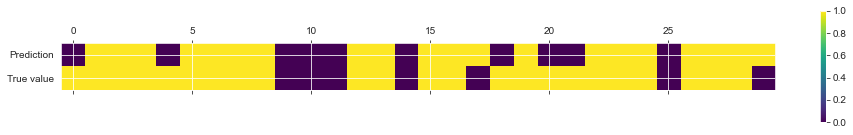

In [694]:
plt.matshow(pred_v_test[:,:30], cmap='viridis')
plt.yticks([0,1],['Prediction', 'True value'])
plt.colorbar()

In [695]:
print('El puntaje de la regresion logistica en el  es de',logreg.score(X_test, y_test)*100, '%')

El puntaje de la regresion logistica en el  es de 74.0 %


In [696]:
from sklearn.metrics import confusion_matrix

conf=pd.DataFrame(confusion_matrix(y_test, logreg.predict(X_test)),
                  index=['Verdadero Malo', 'Verdadero Bueno'],
                  columns=['Prediccion Malo', 'Prediccion Bueno'])

conf

,Prediccion Malo,Prediccion Bueno
Verdadero Malo,37,37
Verdadero Bueno,28,148


## Funcion de perdida

La documentación del dataset incluye una función de pérdida asimétrica para los falsos positivos (5 puntos) y los falsos negativos (1 punto).

In [697]:
def loss_funct(target, prediction):
    conf = confusion_matrix(target, prediction)
    return conf[0,1]*5 + conf[1,0]*1

In [698]:
print('Funcion de perdida de Reg Logistica:',loss_funct(y_test, logreg.predict(X_test)))

Funcion de perdida de Reg Logistica: 213


# Modelizacion con preprocesamiento

In [699]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_trainvalid)
X_trainvalid_scaled = scaler.transform(X_trainvalid)
X_test_scaled = scaler.transform(X_test)

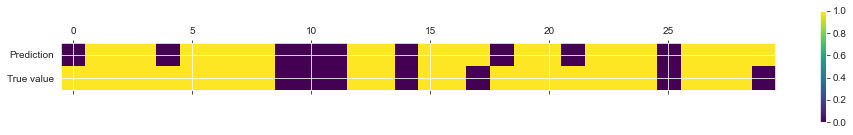

In [700]:
logreg = LogisticRegressionCV(max_iter=10000).fit(X_trainvalid_scaled, y_trainvalid)

pred_v_test = np.array([logreg.predict(X_test_scaled), y_test])

plt.matshow(pred_v_test[:,:30], cmap='viridis')
plt.yticks([0,1],['Prediction', 'True value'])
plt.colorbar()

In [701]:
print('El puntaje de la regresion logistica escalada es de',logreg.score(X_test_scaled, y_test)*100, '%')
print('Funcion de perdida de Reg Logistica Escalada:',loss_funct(y_test, logreg.predict(X_test_scaled)))

El puntaje de la regresion logistica escalada es de 74.0 %
Funcion de perdida de Reg Logistica Escalada: 221


\large Con este preprocesamiento perdemos puntaje pero ganamos interpretabilidad. Al estar preprocesado el dataset, podemos comparar la magnitud de los efectos por la magnitud del coeficiente.

AttributeError: 'AxesSubplot' object has no attribute 'colorbar'

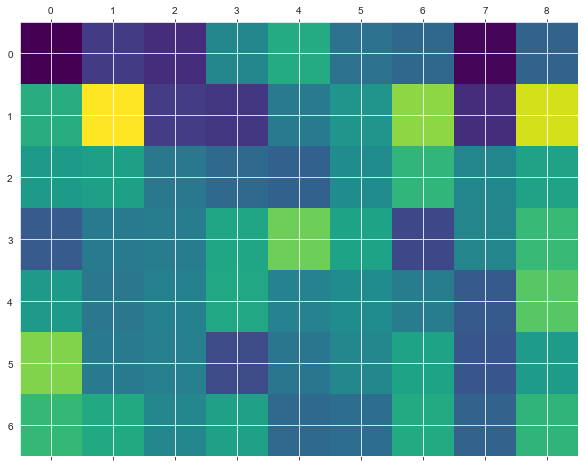

In [748]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.matshow((logreg.coef_).reshape(7,-1), cmap='viridis')

In [707]:
print('Parametro con menor valor:',data_dummies.columns[np.argmin(logreg.coef_)])
print('Menor parámetro:', format(np.min(logreg.coef_),'.3f'))

Parametro con menor valor: duration
Menor parámetro: -0.344


Este resultado va en contra de la expectativa anterior de que a más duración mejor calidad crediticia

In [708]:
print('Parametro con mayor valor:',data_dummies.columns[np.argmax(logreg.coef_)])
print('Mayor parámetro:',format(np.max(logreg.coef_),'.3f'))

Parametro con mayor valor: checking_status_no checking
Mayor parámetro: 0.363


In [710]:
data_dummies["""checking_status_no checking"""].value_counts()

0    606
1    394
Name: checking_status_no checking, dtype: int64

Este resultado parece contraintuitivo: quienes no tienen cuenta tienen mejor calidad crediticia.   
Posible explicación es que vengan clientes de otros bancos.  
Quienes cambien de banco para un prestamo, probablemente tengan habitos financieros que llevan a la solvencia.

# Modelización con optimización de metaparámetros 

In [711]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(StandardScaler(), LogisticRegressionCV(max_iter=5000))

param_grid = {'logisticregressioncv__Cs':[1, 5, 10, 50, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregressioncv',
                                        LogisticRegressionCV(max_iter=5000))]),
             param_grid={'logisticregressioncv__Cs': [1, 5, 10, 50, 100]})

In [712]:
grid.best_params_

{'logisticregressioncv__Cs': 5}

In [713]:
pipe = make_pipeline(StandardScaler(), LogisticRegressionCV(Cs = 5, max_iter=5000))

pipe.fit(X_trainvalid, y_trainvalid)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregressioncv',
                 LogisticRegressionCV(Cs=5, max_iter=5000))])

In [714]:
print('El puntaje de la regresion logistica optimizada es de',pipe.score(X_test, y_test)*100, '%')
print('Funcion de perdida de Reg Logistica optimizada:',loss_funct(y_test, pipe.predict(X_test)))

El puntaje de la regresion logistica optimizada es de 73.2 %
Funcion de perdida de Reg Logistica optimizada: 215


## Calibracion de precision

Dada la funcion de pérdida asimétrica a calibrar la precision del modelo: se define como 

$$precision=\frac{VB}{(VB + FB)}$$

Donde VB y FB son Verdadero Bueno y Falso Bueno.
Es equivalente a calibrar el error tipo I

In [715]:
from sklearn.metrics import precision_recall_curve

pipe = make_pipeline(StandardScaler(), LogisticRegressionCV(Cs = 5, max_iter=5000))

pipe.fit(X_train, y_train)

precision, recall, thresholds = precision_recall_curve(y_valid, pipe.decision_function(X_valid))

Text(0.5, 1.0, 'Curva de Precision vs. Recall')

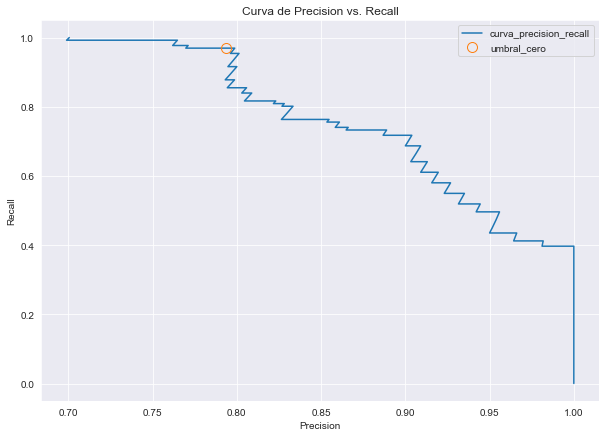

In [716]:
close_zero = np.argmin(np.abs(thresholds))

plt.figure(figsize=(10,7))
plt.plot(precision, recall, label='curva_precision_recall')
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, fillstyle='none', label='umbral_cero')
plt.legend()
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Curva de Precision vs. Recall')

In [717]:
loss_results = []

for threshold in thresholds:
    loss_results.append(loss_funct(y_valid, pipe.decision_function(X_valid) > threshold))

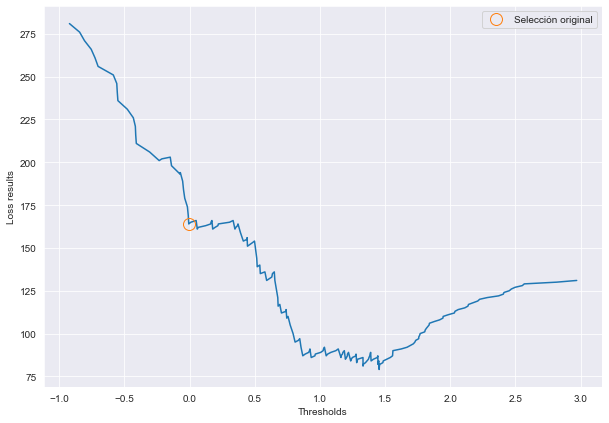

In [749]:
plt.figure(figsize=(10,7))
plt.plot(thresholds, loss_results)
plt.plot(thresholds[close_zero], loss_results[close_zero], 'o', markersize=12, fillstyle='none', label='Selección original')
plt.xlabel('Thresholds')
plt.ylabel('Loss results')
plt.legend()

En el conjunto de validación, un umbral entre 1 y 1.5 parece generar un minimo en la funcion de perdida. 
Usamos 1.2 como calibración manual

In [719]:
calib_thresh = 1.2

print('Funcion de perdida de Reg Logistica con umbral calibrado:',loss_funct(y_test, pipe.decision_function(X_test)>calib_thresh))

Funcion de perdida de Reg Logistica con umbral calibrado: 157


Text(0.5, 1.0, 'Logreg de umbral calibrado')

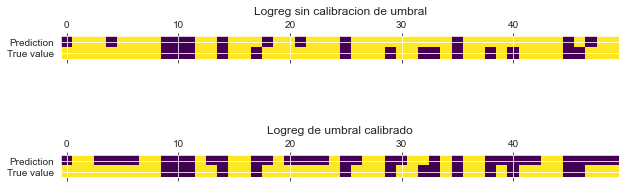

In [720]:
pred_v_test = np.array([logreg.predict(X_test_scaled), y_test])

pred_v_test_calib = np.array([pipe.decision_function(X_test)>calib_thresh, y_test])


fig, axes = plt.subplots(2, 1, figsize=(10,4))

ax1, ax2 = axes.ravel()

ax1.matshow(pred_v_test[:,:50], cmap='viridis')
ax1.set_yticks([0,1])
ax1.set_yticklabels(['Prediction', 'True value'])
ax1.set_title('Logreg sin calibracion de umbral')

ax2.matshow(pred_v_test_calib[:,:50], cmap='viridis')
ax2.set_yticks([0,1])
ax2.set_yticklabels(['Prediction', 'True value'])
ax2.set_title('Logreg de umbral calibrado')

Vemos de inmediato que la regresión con umbral calibrado comete muchos más errores!

Esto se explica por la asimetría entre calificar como bueno a un mal acreedor (Falso positivo, pérdidas) vs. calificar como malo a un buen acreedor (Falso negativo, lucro cesante).

### Coeficientes

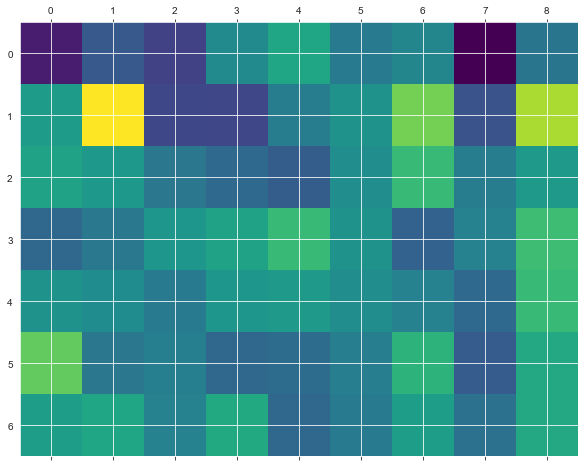

In [725]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.matshow((pipe.named_steps['logisticregressioncv'].coef_).reshape(7,-1), cmap='viridis')

In [726]:
print('Parametro con menor valor:',data_dummies.columns[np.argmin(pipe.named_steps['logisticregressioncv'].coef_)])
print('Menor parámetro:', format(np.min(pipe.named_steps['logisticregressioncv'].coef_),'.3f'))

Parametro con menor valor: checking_status_<0
Menor parámetro: -0.231


In [727]:
print('Parametro con mayor valor:',data_dummies.columns[np.argmax(pipe.named_steps['logisticregressioncv'].coef_)])
print('Mayor parámetro:',format(np.max(pipe.named_steps['logisticregressioncv'].coef_),'.3f'))

Parametro con mayor valor: checking_status_no checking
Mayor parámetro: 0.241


# Comparación con modelización alternativa: Random Forest

In [728]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=2)

rf.fit(X_train, y_train)

RandomForestClassifier(random_state=2)

In [729]:
print('El puntaje del random forest es de', rf.score(X_test, y_test)*100, '%')
print('Funcion de perdida del random forest:', loss_funct(y_test, rf.predict(X_test)))

El puntaje del random forest es de 74.4 %
Funcion de perdida del random forest: 248


Sin optimización, este modelo muestra una función de pérdida similar a los peores modelos.

Text(0.5, 1.0, 'Curva de precision vs. recall')

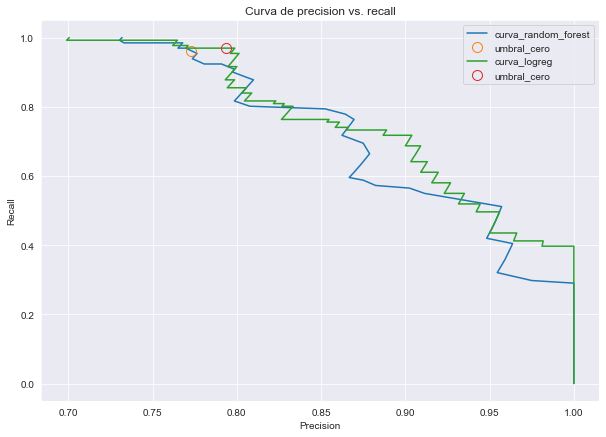

In [730]:
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_valid, rf.predict_proba(X_valid)[:,1])

close_zero = np.argmin(np.abs(thresholds))
close_zero_rf = np.argmin(np.abs(thresholds_rf-0.5))

plt.figure(figsize=(10,7))
plt.plot(precision_rf, recall_rf, label='curva_random_forest')
plt.plot(precision_rf[close_zero_rf], recall_rf[close_zero_rf], 'o', markersize=10, fillstyle='none', label='umbral_cero')

plt.plot(precision, recall, label='curva_logreg')
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, fillstyle='none', label='umbral_cero')

plt.legend()
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Curva de precision vs. recall')

Encontramos que el modelo Logistico parece superar sustancialmente al modelo de random forest casi de forma estricta.  
Evaluamos las funciones de perdida respectivas.

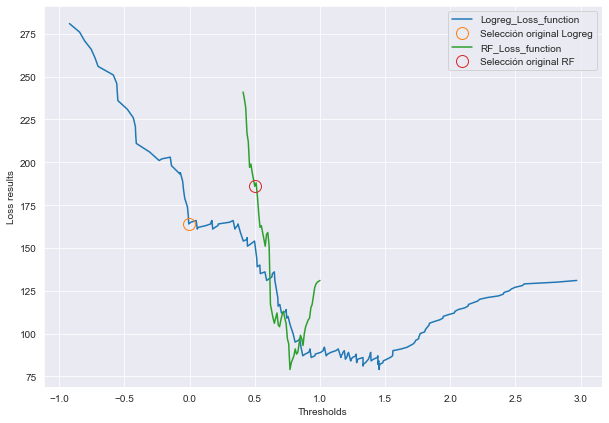

In [731]:
loss_results_rf = []

for threshold in thresholds_rf:
    loss_results_rf.append(loss_funct(y_valid, rf.predict_proba(X_valid)[:,1] > threshold))
    
    
plt.figure(figsize=(10,7))
plt.plot(thresholds, loss_results, label='Logreg_Loss_function')
plt.plot(thresholds[close_zero], loss_results[close_zero], 'o', markersize=12, fillstyle='none', label='Selección original Logreg')

plt.plot(thresholds_rf, loss_results_rf, label='RF_Loss_function')
plt.plot(thresholds_rf[close_zero_rf], loss_results_rf[close_zero_rf], 'o', markersize=12, fillstyle='none', label='Selección original RF')

plt.xlabel('Thresholds')
plt.ylabel('Loss results')
plt.legend()

Parece existir un punto en donde el modelo de Random Forest supera al Logistico.  
Mi expectativa es que la diferencia corresponde sólo a la muestra de validación.

In [732]:
calib_thresh = thresholds[np.argmin(loss_results)]

print('Funcion de perdida de Reg Logistica con umbral calibrado:',loss_funct(y_test, pipe.decision_function(X_test)>calib_thresh))


calib_thresh_rf = thresholds_rf[np.argmin(loss_results_rf)]

print('Funcion de perdida de Random Forest con umbral calibrado:',loss_funct(y_test, rf.predict_proba(X_test)[:,1]>calib_thresh_rf))

Funcion de perdida de Reg Logistica con umbral calibrado: 152
Funcion de perdida de Random Forest con umbral calibrado: 150


Encontramos que la diferencia en el conjunto de prueba es de 0.6%, lo cual puede ser perfectamente atribuido al azar. Sin embargo, contrario a lo mostrado por las curvas de precision y recall, se logra un rendimiento similar para ambos modelos.

# Expectativas

1) No checking y saldo menor a cero sean negativos en cuanto a calidad cred.  

In [734]:
check_subzero= data_dummies.columns.tolist().index("""checking_status_<0""")

print('Coeficiente Checking status <0: ', 
      format(pipe.named_steps['logisticregressioncv'].coef_[:,check_subzero][0], '.3f'))

check_no= data_dummies.columns.tolist().index("""checking_status_no checking""")


print('Coeficiente no Checking:', 
      format(pipe.named_steps['logisticregressioncv'].coef_[:, check_no][0],'.3f'))

Coeficiente Checking status <0:  -0.231
Coeficiente no Checking: 0.241


**MIXTO:** Solo se corrobora una de estas dos expectativas.

2) Las duraciones mas largas tendrán menos problemas en calidad  

In [735]:
dur_no= data_dummies.columns.tolist().index('duration')


print('Coeficiente Duration:', 
      format(pipe.named_steps['logisticregressioncv'].coef_[:, dur_no][0],'.3f'))

Coeficiente Duration: -0.196


**FALSO**

3) Aplicaciones comerciales y de inversión (eg. educación) tendrán menos riesgo que creditos de consumo.  

**FALSO**

In [736]:
for feature in data_dummies.columns.tolist():
    print(feature, 'value:')
    print(format(pipe.named_steps['logisticregressioncv'].coef_[:, data_dummies.columns.tolist().index(feature)][0],'.3f'))
    print('\n')

duration value:
-0.196


credit_amount value:
-0.099


installment_commitment value:
-0.139


residence_since value:
-0.007


age value:
0.047


existing_credits value:
-0.035


num_dependents value:
-0.014


checking_status_<0 value:
-0.231


checking_status_0<=X<200 value:
-0.048


checking_status_>=200 value:
0.028


checking_status_no checking value:
0.241


credit_history_no credits/all paid value:
-0.128


credit_history_all paid value:
-0.130


credit_history_existing paid value:
-0.032


credit_history_delayed previously value:
0.010


credit_history_critical/other existing credit value:
0.143


purpose_new car value:
-0.110


purpose_used car value:
0.182


purpose_furniture/equipment value:
0.041


purpose_radio/tv value:
0.020


purpose_domestic appliance value:
-0.044


purpose_repairs value:
-0.071


purpose_education value:
-0.093


purpose_vacation value:
0.000


purpose_retraining value:
0.089


purpose_business value:
-0.030


purpose_other value:
0.024


savings_statu


4) mayor antiguedad debería correlacionar mejor con estabilidad laboral, por lo tanto, con calidad crediticia.  
**VERDADERO**

5) Mas % del salario ocupado por cada amortización es peor calidad.   
**VERDADERO**

6) mayor antiguedad laboral debería correlacionar con calidad crediticia.  
**VERDADERO**

7) mayor edad debería correlacionar con riqueza, y por ende, calidad crediticia.  
**VERDADERO**

8) alquilar genera salidas de flujos de fondos mensuales y se asocian con menor riqueza, lo que impacta en calidad crediticia. Adicionalmente, propietarios podrían refinanciar con creditos hipotecarios.  
**VERDADERO**

9) Ser extranjero correlaciona con los costos de instalarse y falta de redes. Por tanto, es negativo para la calidad crediticia.  
**VERDADERO**  
  

Un modelo del tipo caja blanca como la Regresion Logistica permite dar intepretabilidad a los parámetros. Este mismo análisis no se podría hacer con el Random Forest.

N.B. Verdadero/Falso no se refiere a que la interpretación del parámetro, si no a la dirección del parámetro.